# STOCK ANOMALIES/ HIGH VOLATILITY
Below the Class (copy pasted from ".py" script) we use to identify anomalous days. The methodology as explained in the research paper.

In [35]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# General class that can handle different stocks, rolling windows and z-scores
# to calculate, retrieve and display anomaly trading days.

class StockAnomaly:
    def __init__(self,
                 stocks:list[str] = None,
                 history:str = None,
                 start:datetime|str = None,
                 end:datetime|str = None):
        
        # Set stocks used in our research project if none are provided
        self.stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"] if not stocks else stocks
        self.history = '5y' if not history else history # 5y default time period to get history of
        self.start = start # Set specific start and end period to get stock information of.
        self.end = end
        self.stocks_data = yf.Tickers(self.stocks) # Initialise the yFinance with stocks provided.

        # Get the history of one of provided timespans.
        if start and end:
            self.stocks_history = self.stocks_data.history(start=self.start, end=self.end, interval="1d")
        else:
            self.stocks_history = self.stocks_data.history(self.history, interval="1d")
        
        self.__stocks_history_df = self.stocks_history.copy() # Create a 'private' dataframe to keep a ground truth of the stock data
        self.did_calculate_anomalies = False # Has the method calculate succesfully been called yet.


    # Calculate anomaly trading days based on window days history, and z-values for price and volume.
    def calculate(self, window = 30, price_z = 2.5, volume_z = 2.5):
        if self.did_calculate_anomalies and window == self.window and price_z == self.price_z and self.volume_z == volume_z:
            # Unusual days are already calculated
            return True
        
        # Hyper parameters we can fine tune
        self.window = window # Rolling window size in days
        
        # Z-scores: 1 = normal, 2 >= unusual, 3 >= outlier (Bollinger bands takes z-score of >= 2)
        self.price_z = price_z # From what z-score is price change an anomaly
        self.volume_z = volume_z # From what z-score is trading volume an anomaly
        stocks_history = self.__stocks_history_df.copy()

        # Calculate anomaly trading days for all provided stocks.
        for internal_stock in self.stocks:
            
            # ================ PRICE ================
            # Calculate day by day closing price change in percentage of stock
            stocks_history['return', internal_stock] = stocks_history['Close', internal_stock].pct_change()
            
            # Calculate rolling mean and standard deviation per stock
            stocks_history['rolling_mean_P', internal_stock] = stocks_history['return', internal_stock].rolling(window).mean()
            stocks_history['rolling_std_P', internal_stock] = stocks_history['return', internal_stock].rolling(window).std()
            
            # Calculate z-score of rolling window
            stocks_history['rolling_z_P', internal_stock] = (
                (stocks_history['return', internal_stock] - stocks_history['rolling_mean_P', internal_stock]) / stocks_history['rolling_std_P', internal_stock]
            )

            # Anomaly trading day if z-score >= prive_z, outlier in price change detected.
            # Based on price alone:
            # stocks_history['unusual', stock] = stocks_history['rolling_z_P', stock] >= price_z

            # ================ VOLUME ================
            stocks_history['rolling_mean_V', internal_stock] = stocks_history['Volume', internal_stock].rolling(window).mean()
            stocks_history['rolling_std_V', internal_stock] = stocks_history['Volume', internal_stock].rolling(window).std()

            stocks_history['rolling_z_V', internal_stock] = (
                (stocks_history['Volume', internal_stock] - stocks_history['rolling_mean_V', internal_stock]) / stocks_history['rolling_std_V', internal_stock]
            )

            # Based on volume alone:
            # stocks_history['unusual', stock] = stocks_history['rolling_z_V', stock] >= volume_z

            # Anomaly trading day if price and volume are outlier based on past {window} days.
            stocks_history['unusual', internal_stock] = (
                (stocks_history['rolling_z_P', internal_stock].abs() >= price_z) 
                &
                (stocks_history['rolling_z_V', internal_stock].abs() >= volume_z)
            )

        self.stocks_history = stocks_history.copy() # Set global stocks_history to df containing all calcualted variables above.
        self.did_calculate_anomalies = True # Method succesfully calcualted anomaly trading days.
        self.__transform_for_output() # Convert the dataframe to right format.
        return True
    
    # Convert multilevel stock history dataframe to a dataframe with anomaly trading days' stock, date and rolling z-score values.
    def __transform_for_output(self):
        stocks_history = self.stocks_history.copy()

        # Convert multilevel df to single level dataframe.
        output = (
            stocks_history
            .stack(level=1, future_stack=True)
        )
        output = output[output['unusual']] # Filter all unusual days
        output = output[['rolling_z_P', 'rolling_z_V']] # Retrieve only rolling values
        
        output = (
            output
            .reset_index()
            .rename(columns={'Ticker': 'stock', 'Date': 'date'}) # Rename columns
            .sort_values(['stock', 'date']) # Sort by stock then date
            .reset_index(drop=True) # reset index
        )
        output.columns.name = "index"

        self.__output_stocks_history = output
        return True
    

    # Retrieve all anomaly trading days in either dataframe or list.
    def get_anomalies(self, stock:str = None, get_dict_dates:bool = False):
        # Check if the anomalies have been calculated yet, else throw exception.
        if not self.did_calculate_anomalies:
            raise Exception("Anomalies of stocks are not calculated. Run `self.calculate()` before running this function.")
        
        output = None

        # If a specific stock was provided, only return anomaly days for that stock, else output data for all calculated stocks.
        if type(stock) == str:
            if stock not in self.stocks:
                raise Exception(f"Stock: {stock} doesn't exist or does not exist in the current calculation.")
            output = self.__output_stocks_history[self.__output_stocks_history["stock"] == stock].reset_index(drop=True)
        else:
            output = self.__output_stocks_history
        

        if get_dict_dates:
            return output.groupby('stock')['date'].agg(list).to_dict() # Provide stock with list of dates instead of all z-score information.
        return output


    # Plot a graph of the closing price, rolling average and draw lines at anomaly trading days of stock(s).
    def display_anomalies(self, stock = None,figsize:tuple = (12,5)):
        # Throw exceptions if the right data wasn't provided or does not yet exist.
        if not self.did_calculate_anomalies:
            raise Exception("Anomalies of stocks are not calculated. Run `self.calculate()` before running this function.")
        
        stocks = self.stocks
        if stock is not None:
            if stock not in self.stocks:
                raise Exception(f"Stock: {stock} doesn't exist or does not exist in the current calculation.")
            stocks = [stock]

        # Plot stock data: price, rolling average and anomalies
        for internal_stock in stocks:
            # Get index of all unusual trading days
            unusual_days = self.stocks_history[self.stocks_history["unusual", internal_stock]].index

            # Plot closing prices
            plt.figure(figsize=figsize)
            plt.plot(self.stocks_history['Close', internal_stock], 
                    label = "Closing price"
                    )
            
            # Plot rolling average
            plt.plot(
                self.stocks_history['Close', internal_stock].rolling(self.window).mean(),
                label=f"Rolling average price ({self.window} days)"
                )

            # Plot vertical lines at each unusual day
            plt.vlines(
                    unusual_days,
                    ymin=0,
                    ymax=self.stocks_history['Close', internal_stock].max(),
                    color = 'red',
                    linestyle='-', 
                    alpha=0.3, 
                    linewidth=1,
                    label=f'Anomalies (z_P = {self.price_z}, z_V = {self.volume_z})'
                )

            # State dates of anomalies
            for anomaly_day in unusual_days:
                plt.text(anomaly_day, 0, f"{anomaly_day.strftime('%d-%m-%Y')}", rotation = 90)

            plt.legend()
            plt.title(f"{internal_stock}: Unusual Trading Days")
            plt.show()


# if '__main__' == __name__:

#     print('Running Test')
    
#     stock_anomaly = StockAnomaly()

#     stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

#     print(stock_anomaly.get_anomalies(get_dict_dates=True))

In [36]:
import pandas as pd
import torch
import torch.nn.functional as F
# from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)

def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s
    Compute finbert sentiment on the text.
    - max_lenght=512 for stability
    - SoftMax to ensure equal weights'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def count_positive(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('positive', 0)

def count_negative(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('negative', 0)

def count_neutral(group_series):
    """
    Count Positive
    """
    counts = group_series.value_counts()

    return counts.get('neutral', 0)

def calc_conviction(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus/agreement.
    Lower value = High disagreement or mostly neutral news.
    Slightly modified to take into account neutral article -> conviction Index
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    conviction = 1 - np.sqrt(1 - inner_val)
    
    return conviction

def compute_volatility(df):
    """Compute volatility following Antweiller and Frank Methodology
    - residual of MA1
    - log Squared residuals
    - added variation with soxx(index for tech industries)"""
    # MA 1
    model = ARIMA(df['log_return'], order=(0, 0, 1))
    model_fit = model.fit()    

    df['ln_vi_t'] = np.log(model_fit.resid**2)

    df['ln_vi_t_soxx'] = np.log((df['log_return']-df['soxx_ret'])**2)
    
    return df

def add_ts(metrics):

    """Features Engineering, adding indicators and dummy variables
    get everything in Panel Format for regression, as well shift position
    (lag variables)"""

    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]

    stocks_data = yf.Tickers(stocks)
    hist = stocks_data.history(period='4y', interval="1d")
    
    data_subset = hist[['Close', 'Volume', 'Dividends']]
    prices_long = data_subset.stack(level=1).reset_index()
    prices_long.columns = ['date', 'label', 'price', 'volume', 'dividend']

    prices_long['dividend_dummy'] = np.where(prices_long['dividend'] > 0, 1, 0)
    
    prices_long = prices_long.sort_values(['label', 'date'])

    prices_long['log_return'] = prices_long.groupby('label')['price'].transform(
        lambda x: 100*np.log(x/x.shift(1))
    )
    
    prices_long['log_return_lag'] = prices_long.groupby('label')['log_return'].shift(1)
    prices_long['lag_neg'] = np.where(prices_long['log_return_lag']<0,1,0)

    prices_long['log_volume'] = np.log(prices_long['volume'])
    prices_long['log_volume_lag'] = prices_long.groupby('label')['log_volume'].shift(1)

    prices_long['date'] = prices_long['date'].dt.strftime('%Y-%m-%d')

    soxx = yf.Ticker("SOXX").history(period='5y')[['Close']]
    soxx['soxx_ret'] = 100*np.log(soxx['Close']/soxx['Close'].shift(1))
    soxx.index = pd.to_datetime(soxx.index.date).strftime('%Y-%m-%d')
    soxx = soxx[['soxx_ret']].reset_index().rename(columns={'index': 'date'})

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')
    combined_df = combined_df.merge(soxx, on='date', how='left')

    combined_df['bullishness_lag'] = combined_df.groupby('label')['bullishness_index'].shift(1)
    combined_df['conviction_lag'] = combined_df.groupby('label')['conviction_index'].shift(1)
    combined_df['article_count_lag'] = combined_df.groupby('label')['article_count'].shift(1)
    combined_df['n_positive_lag'] = combined_df.groupby('label')['n_positive'].shift(1)
    combined_df['n_neutral_lag'] = combined_df.groupby('label')['n_neutral'].shift(1)
    combined_df['n_negative_lag'] = combined_df.groupby('label')['n_negative'].shift(1)
    combined_df['soxx_ret_lag'] = combined_df.groupby('label')['soxx_ret'].shift(1)

    combined_df = combined_df.dropna()

    combined_df.sort_values('date',ascending=True,inplace=True)

    combined_df = combined_df.groupby('label', group_keys=False).apply(compute_volatility)

    return combined_df

Device set to use cuda:0


# ARTICLES
We scrape the article as explain in the paper. We took the codes a youtube video (https://www.youtube.com/watch?v=5tpEDlUCzjk). Initially the codes where limited to headers. We extended his work to also enter into the url and clened the articles. Moreover we speeded up the scraping x10 by using parallelization. For sake of brevity we will just print the codes below. It takes more than one hour to run.

In [37]:
import requests

url = "https://raw.githubusercontent.com/LeonSavi/T-M-Project/refs/heads/master/multi_threading_scraper.py"

print(requests.get(url).text)

import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from newspaper import Article
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# Improved Version of https://www.youtube.com/watch?v=5tpEDlUCzjk

# Configuration
STOCKS = ["AMD", "ASML", "GOOG", "META", "NVDA"]
PAGES_PER_STOCK = 500
MAX_WORKERS = 20  # Number of concurrent threads
ROOT_URL = 'https://markets.businessinsider.com'

# Thread-safe storage
results_lock = threading.Lock()
pandas_dct = defaultdict(list)

def get_article_content(url):
    """Downloads and parses a single article."""
    try:
        article = Article(url)
        article.download()
        article.parse()
        txt = article.text
        paragraphs = [p.strip() for p in txt.split('\n') if p.strip()]
        first_paragraph = paragraphs[0] if paragraphs else ""
        return txt, first_paragraph
    except Exception:
        return None, None

def proces

# DATA
Data are scraped as mentioned above and run. Below you load the row data and assign the sentiment with FinBERT. Description of how finbert_sentiment works is in the paper and youtube video (https://www.youtube.com/watch?v=4KoYlMii8hM).

In [38]:
# GET DATA PARQUET FROM GITHUB REPO
url = "https://github.com/LeonSavi/T-M-Project/raw/refs/heads/master/scraped_data.parquet"

data = pd.read_parquet(url,engine='auto')

SENTIMENT_REF_COLUMN = 'fist_parag'

data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data[SENTIMENT_REF_COLUMN].apply(finbert_sentiment).apply(pd.Series)

# INDICATORS
Compute indicators, including:calc_bullishness,calc_agreement, count_positive,count_neutral, count_negative, count_article. Filter for finbert sentiments with 0.5 probabilities or above. Moreover add Returns for each stock and more. More details in the functions.

In [39]:
# compute metrics i.e. market bullishness and agreement
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)

# filter for certain articles

TRESHOLD = 0.5
cond = (
    ((data['fb_positive']>TRESHOLD) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>TRESHOLD) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>TRESHOLD) & (data['sentiment']=='negative'))
)

metrics = data[cond].groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    conviction_index = calc_conviction,
    article_count = 'count',
    n_positive = count_positive,
    n_neutral = count_neutral,
    n_negative = count_negative

)

clean_data = add_ts(metrics)

clear_output()

# REGRESSION 1
Regression as in the paper of Antweiler and Frank 2004 for volatility analysis.

In [40]:
# volatility as in the paper
X_returns = clean_data[['conviction_lag',
                        'article_count_lag',
                        'lag_neg',
                        'log_volume_lag'
                        ]]
X_returns = sm.add_constant(X_returns)
y_returns = clean_data['ln_vi_t']

model_returns = sm.OLS(y_returns, X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.48
Date:                Sun, 01 Feb 2026   Prob (F-statistic):           3.13e-09
Time:                        18:39:59   Log-Likelihood:                -5396.1
No. Observations:                2375   AIC:                         1.080e+04
Df Residuals:                    2370   BIC:                         1.083e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.0803      0.64

# ANOMALIES/HIGH VOLATILITY EVENTS
Get High Vol event as described in the paper. We run our add-hoc class to identify them. More detail in the class.

In [41]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

anomalies = stock_anomaly.get_anomalies()
anomalies['date'] = anomalies['date'].dt.strftime('%Y-%m-%d')
anomalies['high_volatility'] = int(1)

merged_data = clean_data.merge(anomalies[['date','stock','high_volatility']],
                              how='left',
                              left_on = ['date', 'label'],
                              right_on = ['date','stock'])

merged_data.drop(columns='stock',inplace=True)
merged_data['high_volatility'] = merged_data['high_volatility'].fillna(0)
merged_data['high_vol_tmrrw'] = merged_data['high_volatility'].shift(-1)

[*********************100%***********************]  5 of 5 completed


# WEIGHTING
Compute Weights for Logistic Regression. As there are few anomalous days we give more weights to those.

In [42]:
# weighting
n_total = len(merged_data)
n_events = merged_data['high_volatility'].sum()
n_normal = n_total - n_events

# Weight for the rare event (Class 1) and normal day (Class 0)
weight_event = n_total / (2 * n_events)
weight_normal = n_total / (2 * n_normal)

weights = merged_data['high_volatility'].apply(lambda x: weight_event if x == 1 else weight_normal)
n_events,n_normal

(np.float64(58.0), np.float64(2317.0))

# REGRESSION 2
Logistic Regression for probablity of Anomalous day (High Volatility Event).

In [43]:
pred = ['bullishness_lag',
        'conviction_lag',
        'article_count_lag',
        'lag_neg',
        'log_volume_lag']

predictors = sm.add_constant(
    merged_data[pred]
)

weighted_model = sm.GLM(merged_data['high_volatility'], predictors,
                        family=sm.families.Binomial(), freq_weights=weights).fit()

print(weighted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        high_volatility   No. Observations:                 2375
Model:                            GLM   Df Residuals:                     2369
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1626.0
Date:                Sun, 01 Feb 2026   Deviance:                       3252.0
Time:                        18:40:00   Pearson chi2:                 2.38e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01687
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8569      0.52

# CHARTS
Additional Charts to support regressions.
1. Mean Volatility by conviction group
2. Probability of an high volatility event by bullishness bucket
3. Anomalous/high volatility days charts

/tmp/ipykernel_96893/3257763284.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='conviction_group',


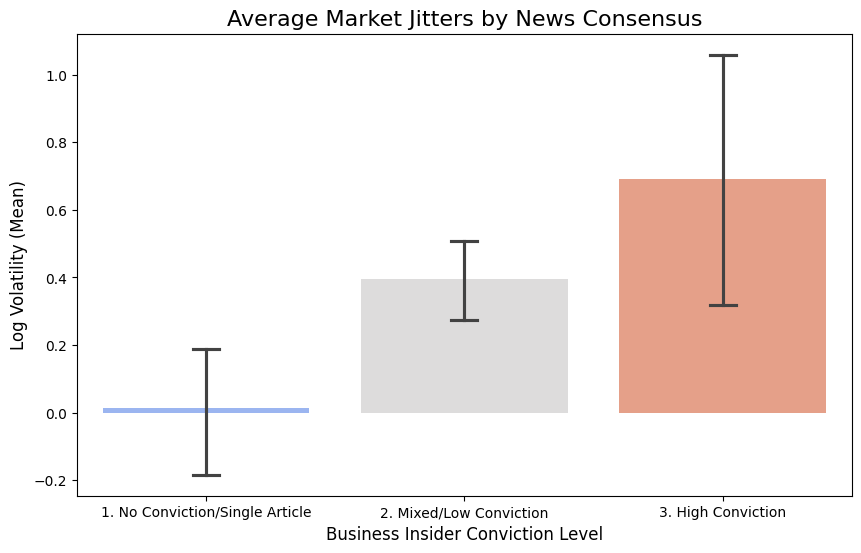

In [44]:
def categorize_conviction(x):
    if x == 0: return "1. No Conviction/Single Article"
    if x < 0.5: return "2. Mixed/Low Conviction"
    return "3. High Conviction"

clean_data['conviction_group'] = clean_data['conviction_lag'].apply(categorize_conviction)

plt.figure(figsize=(10, 6))
sns.barplot(x='conviction_group',
            y='ln_vi_t',
            data=clean_data,
            palette='coolwarm',
            capsize=.1,
            order=[
    "1. No Conviction/Single Article", 
    "2. Mixed/Low Conviction", 
    "3. High Conviction"
        ])

plt.title('Average Market Jitters by News Consensus', fontsize=16)
plt.xlabel('Business Insider Conviction Level', fontsize=12)
plt.ylabel('Log Volatility (Mean)', fontsize=12)
plt.show()

/tmp/ipykernel_96893/1272745870.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100
/tmp/ipykernel_96893/1272745870.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')


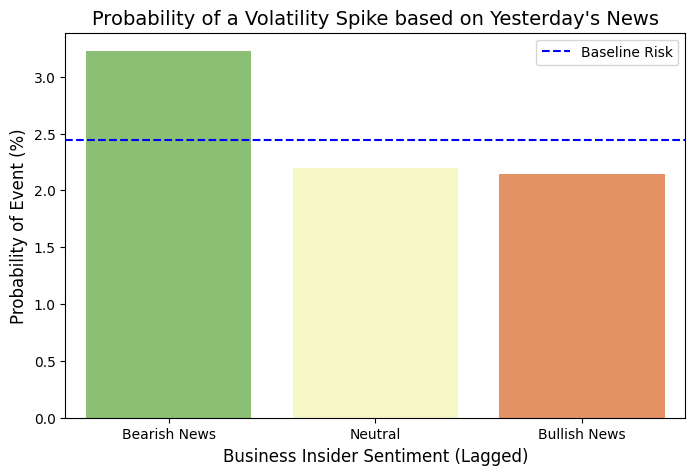

In [45]:
# Bullishness Buckets
merged_data['sentiment_type'] = pd.cut(merged_data['bullishness_lag'], 
                                       bins=[-np.inf, -0.1, 0.1, np.inf], 
                                       labels=['Bearish News', 'Neutral', 'Bullish News'])

# Calculate the Probability
prob_df = merged_data.groupby('sentiment_type')['high_volatility'].mean() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=prob_df.index, y=prob_df.values, palette='RdYlGn_r')

plt.title('Probability of a Volatility Spike based on Yesterday\'s News', fontsize=14)
plt.ylabel('Probability of Event (%)', fontsize=12)
plt.xlabel('Business Insider Sentiment (Lagged)', fontsize=12)
plt.axhline(merged_data['high_volatility'].mean()*100, color='blue', linestyle='--', label='Baseline Risk')
plt.legend()
plt.show()

[*********************100%***********************]  5 of 5 completed


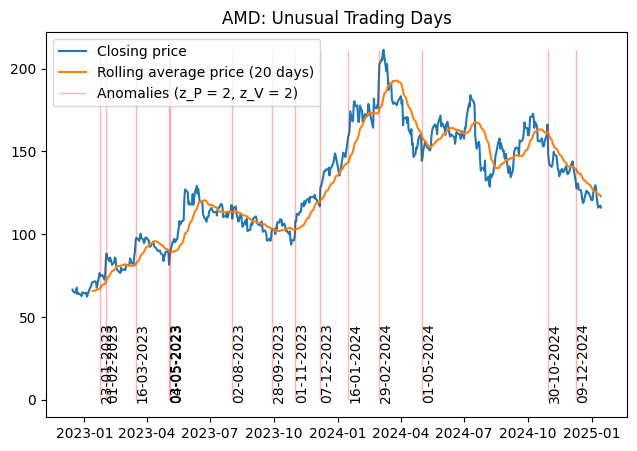

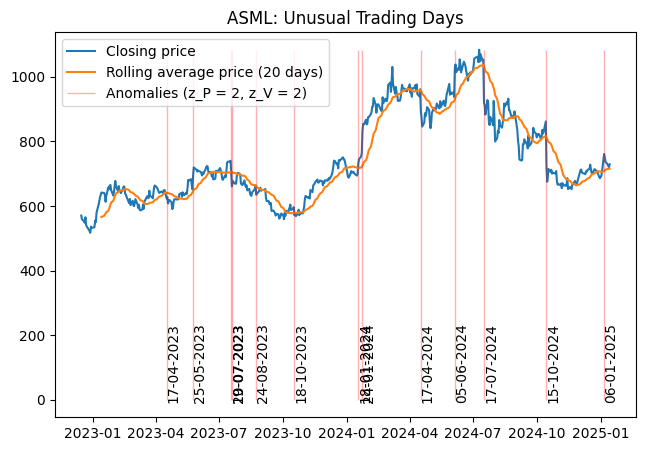

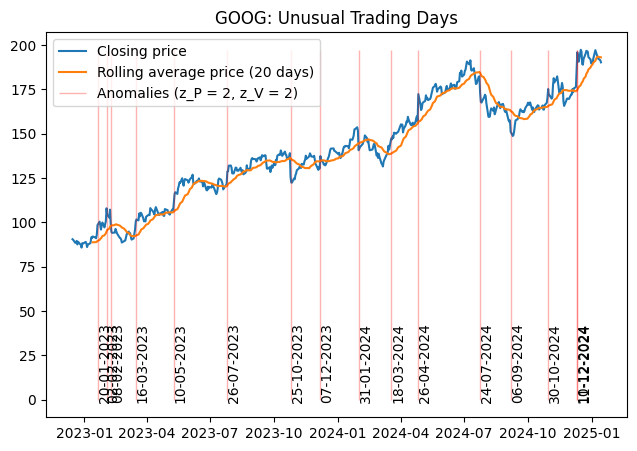

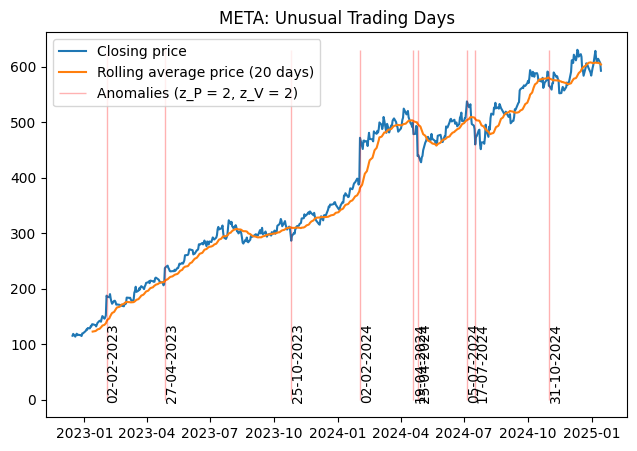

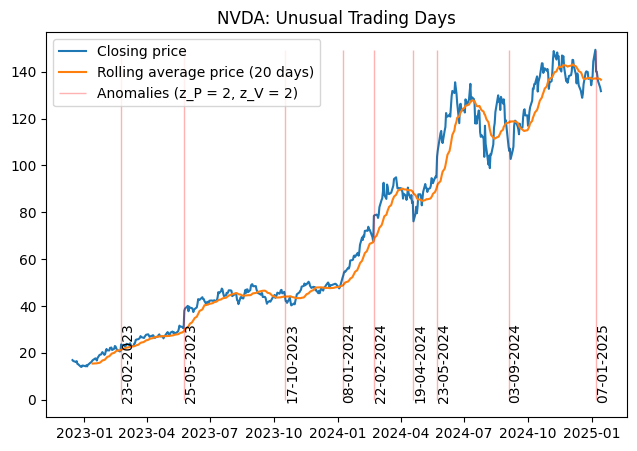

In [46]:
anomalies = StockAnomaly(start='2022-12-15',end='2025-01-15')
anomalies.calculate(window=20,price_z=2,volume_z=2)

for i in anomalies.stocks:
    anomalies.display_anomalies(i,(7.5,5))